--- 
description: Here we show how to solve job sequencing problems with integer lengths using JijZept and JijModeling.
---

# Job Sequencing Problem with Integer Lengths

Here we show how to solve job sequencing problems with integer lengths using JijZept and JijModeling. 
This problem is also described in 6.3. Job Sequencing with Integer Lengths on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Job Sequencing Problem with Integer Lengths?

We consider several tasks with integer lengths (i.e., task 1 takes one hour to execute on a computer, task 2 takes three hours, and so on).
We ask: when distributing these tasks to multiple computers, what combinations can be the optimal solution to distribute these computers' execution time without creating bias?

### Example

Let's take a look at the following situation.

> Here are 10 tasks and 3 computers. 
> The length of each of the 10 tasks is 1, 2, ..., 10.
> Our goal is to assign these tasks to the computers and minimize the maximum amount of time the tasks take.
> In this case, the optimal solution is $\{1, 2, 7, 8\}, \{3, 4, 5, 6\}$ and $\{9, 10\}$, whose maximum of execution time of computers is 19.

![](./assets/integer_jobs_01.png)

### Generalization

Next, we introcude $N$ tasks $\{0, 1, ..., N-1\}$ and list of the execution time $\bm{L} = \{L_0, L_1, ..., L_{N-1}\}$. 
Given $M$ computers, the total execution time of $j$-th computer to perform its assigned tasks is $A_j = \sum_{i \in V_j} L_i$ where $V_j$ is a set of assigned tasks to $j$-th computer.
Finally, let us denote $x_{i, j}$ to be a binary variable which is 1 if $i$-th task is assigned to $j$-th computer, and 0 otherwise.

**Constraint: each task must be assigned to one computer**

For instance, it is forbidden to assign the 5th task to the 1st and 2nd computers simultaneously.
We express this constraint as follows:

$$
\sum_{j=0}^{M-1} x_{i, j} = 1 \quad (\forall i \in \{0, 1, ..., N-1\}) \tag{1}
$$

**Objective function: minimize the difference between the execution time of the 0th computer and others**

We consider the execution time of the 0th computer as the reference and minimize the difference between it and others.
This reduces the execution time variability and tasks are distributed equally.

$$
\min \quad \sum_{j=1}^{M-1} (A_0 - A_j)^2 \tag{2}
$$

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm


# defin variables
L = jm.Placeholder('L', ndim=1)
N = L.len_at(0, latex="N")
M = jm.Placeholder('M')
x = jm.BinaryVar('x', shape=(N, M))
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, M))

`L` is a one-dimensional array representing the execution time of each task.
`N` denotes the number of tasks.
`M` is the number of computers.
Then, we define a two-dimensional list of binary variables `x`. 
Finally, we set the subscripts `i` and `j` used in the mathematical model.

### Constraint

We implement a constraint Equation (1).

In [2]:
# set problem
problem = jm.Problem('Integer Jobs')
# set constraint: job must be executed using a certain node
problem += jm.Constraint('onehot', x[i, :].sum()==1, forall=i)

`x[i, :].sum()` is syntactic sugar of `sum(j, x[i, j])`.

### Objective function

Next, we implement an objective function Equation (2).

In [3]:
# set objective function: minimize difference between node 0 and others
A_0 = jm.sum(i, L[i]*x[i, 0])
A_j = jm.sum(i, L[i]*x[i, j])
problem += jm.sum((j, j!=0), (A_0 - A_j) ** 2)

`sum((j, j!=0), ...)` denotes taking the sum of all cases where j is not 0.

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We set the execution time of each job and the number of computers.
At this time, we use the same values from an example as we describe before.

In [5]:
# set a list of jobs
inst_L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# set the number of Nodes
inst_M = 3
instance_data = {'L': inst_L, 'M': inst_M}

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [6]:
import jijzept as jz

# set sampler
config_path = "./config.toml"
sampler = jz.JijSASampler(config=config_path)
# solve problem
multipliers = {"onehot": 0.5}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Visualize the solution

In the end, we extract the lowest energy solution from the feasible solutions and visualize it.

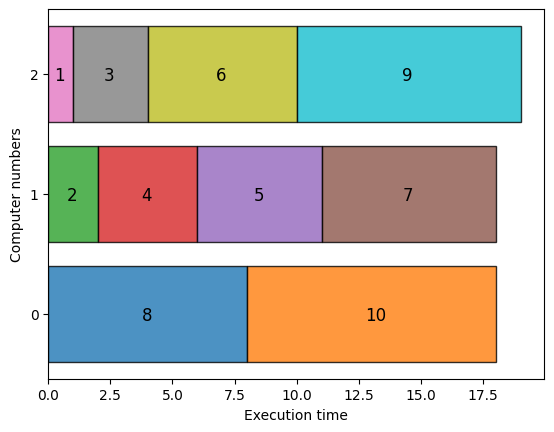

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# extract feasible solution
feasibles = results.feasible()
# get the index of the lowest objective function
objectives = np.array(feasibles.evaluation.objective)
lowest_index = np.argmin(objectives)
# get indices of x = 1
indices, _, _ = feasibles.record.solution['x'][lowest_index]
# get task number and execution node
tasks, nodes = indices
# get instance information
L = instance_data['L']
M = instance_data['M']
# initialize execution time
exec_time = np.zeros(M, dtype=np.int64)
# compute summation of execution time each nodes
for i, j in zip(tasks, nodes):
    plt.barh(j, L[i], left=exec_time[j],ec="k", linewidth=1,alpha=0.8)
    plt.text(exec_time[j] + L[i] / 2.0 - 0.25 ,j-0.05, str(i+1),fontsize=12)
    exec_time[j] += L[i]
plt.yticks(range(M))
plt.ylabel('Computer numbers')
plt.xlabel('Execution time')
plt.show()

With the above visualization, we obtain a graph where the execution times of three computers are approximately equal.
The maximum execution time is still 19, so this is optimal solution.